# Load in Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime as dt

In [2]:
income_df = pd.read_csv('Data/datasets_2647_4395_MedianHouseholdIncome2015.csv', encoding = "ISO-8859-1")
poverty_df = pd.read_csv('Data/datasets_2647_4395_PercentagePeopleBelowPovertyLevel.csv', encoding = "ISO-8859-1")
school_df = pd.read_csv('Data/datasets_2647_4395_PercentOver25CompletedHighSchool.csv', encoding = "ISO-8859-1")
killings_df = pd.read_csv('Data/datasets_2647_4395_PoliceKillingsUS.csv', encoding = "ISO-8859-1")
race_df = pd.read_csv('Data/ShareRaceByCity.csv', encoding = "ISO-8859-1")

In [3]:
# Look at size of datasets, data types, and number of nulls

df_list = [income_df, poverty_df, school_df, race_df, killings_df]

for df in df_list:
    print(df.info())
    print('-------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29322 entries, 0 to 29321
Data columns (total 3 columns):
Geographic Area    29322 non-null object
City               29322 non-null object
Median Income      29271 non-null object
dtypes: object(3)
memory usage: 687.4+ KB
None
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
Geographic Area    29329 non-null object
City               29329 non-null object
poverty_rate       29329 non-null object
dtypes: object(3)
memory usage: 687.5+ KB
None
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29329 entries, 0 to 29328
Data columns (total 3 columns):
Geographic Area         29329 non-null object
City                    29329 non-null object
percent_completed_hs    29329 non-null object
dtypes: object(3)
memory usage: 687.5+ KB
None
-------------------------------------------------
<

# Data Cleaning

## Combine Demographic Data

In [4]:
# Preliminary Cleaning

for df in df_list:
    
    df.columns = df.columns.str.replace(' ', '_')
    df.rename(str.lower, axis='columns', inplace=True)

    if 'geographic_area' in df.columns:
        df.rename(columns={'geographic_area': 'state'}, inplace=True)

    df.city = df.city.str.title()
    df.city = df.city.str.replace(' ', '_')
    df.state = df.state.str.upper()

### Clean up `City` columns

- The demographic tables have the geographic type tacked on the end of each city (e.g. city, town, CDP, etc.)
    - These will need to be removed so that the demographics can be merged with `killings_df`

In [5]:
def clean_cities(df):
    
    clean_city_list = []
    
    for city in df.city.str.split('_').values:
        clean_city = '_'.join(city[:-1])
        clean_city_list.append(clean_city)
    
    df.drop(columns = ['city'], inplace=True)
    df.insert(1, 'city', clean_city_list)
    
    return df

In [6]:
for df in df_list[:-1]:
    df = clean_cities(df)

### Create Merge Key

- City + State creates unqiue key for each row (there are multiple cities with the same name that need to be differentiated)

In [7]:
for df in df_list:
    df.insert(0, 'merge_key', df['city'] + '_' + df['state'])

In [8]:
race_df.columns

Index(['merge_key', 'state', 'city', 'share_white', 'share_black',
       'share_native_american', 'share_asian', 'share_hispanic'],
      dtype='object')

In [9]:
demographics_df = poverty_df.merge(school_df[['percent_completed_hs','merge_key']], how='outer', on='merge_key')    \
                            .merge(race_df[['share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic', 'merge_key']], how='outer', on='merge_key')    \
                            .merge(income_df[['median_income','merge_key']], how='outer', on='merge_key')

In [10]:
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30756 entries, 0 to 30755
Data columns (total 11 columns):
merge_key                30756 non-null object
state                    30673 non-null object
city                     30673 non-null object
poverty_rate             30673 non-null object
percent_completed_hs     30673 non-null object
share_white              30612 non-null object
share_black              30612 non-null object
share_native_american    30612 non-null object
share_asian              30612 non-null object
share_hispanic           30612 non-null object
median_income            30608 non-null object
dtypes: object(11)
memory usage: 2.8+ MB


## Merge `killings_df` with `demographics_df`

In [11]:
merge_df = demographics_df.copy()

In [12]:
merge_df.drop(columns = ['city', 'state'], inplace=True)

In [13]:
killings_df = killings_df.merge(merge_df, how='left', on='merge_key')

## Replace Null Values

- armed: unknown
- age: replace with median of the state
- race: not identified
- flee: not applicable
- demographics: replace with nearby city values

In [14]:
# fill armed nulls

killings_df.armed.fillna('Unknown', inplace=True)

In [15]:
# fill age nulls

age_no_nulls = killings_df[killings_df.age.isna() == False]

median_age_dict = {}

for state in set(killings_df.state.values):
    median_age_dict[state] = np.median(age_no_nulls[killings_df.state == state].age.values)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [16]:
killings_df.age.fillna(-100, inplace=True)

for index, row in killings_df.iterrows():
    for key, value in median_age_dict.items():
        if key == row.state and row.age < 0:
            killings_df.loc[index, 'age'] = value

In [17]:
# fill race nulls

killings_df.race.fillna('Not Identified', inplace=True)

In [18]:
# fill flee nulls

killings_df.flee.fillna('Not Applicable', inplace=True)

In [19]:
# fill poverty_rate, percent_completed_hs, and median_income nulls

for index, row in killings_df.iterrows():
    if row.city == 'Macon':
        killings_df.loc[index, 'poverty_rate'] = killings_df[killings_df.city == 'Fort_Valley'].poverty_rate.values[0]
        killings_df.loc[index, 'percent_completed_hs'] = killings_df[killings_df.city == 'Fort_Valley'].percent_completed_hs.values[0]
        killings_df.loc[index, 'median_income'] = killings_df[killings_df.city == 'Fort_Valley'].median_income.values[0]

In [20]:
# fill median_income nulls

for index, row in killings_df.iterrows():
    if row.city == 'Indianapolis':
        killings_df.loc[index, 'median_income'] = killings_df[killings_df.city == 'Beech_Grove'].median_income.values[0]


In [21]:
killings_df[killings_df.median_income == '-']

,merge_key,id,name,date,manner_of_death,armed,age,gender,race,city,...,flee,body_camera,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
47,Chapeno_TX,88,Miguel Angel de Santos-Rodriguez,21/01/15,shot,gun,36.0,M,H,Chapeno,...,Foot,False,31.7,33.3,100,0,0,0,97.9,-


In [22]:
for index, row in killings_df.iterrows():
    if row.median_income == '(X)':
        killings_df.loc[index, 'median_income'] = np.nan
    elif row.median_income == '-':
        killings_df.loc[index, 'median_income'] = np.nan

In [23]:
killings_df = killings_df.astype({'median_income': 'float64'})

In [24]:
income_no_nulls = killings_df[killings_df.median_income.isna() == False]

median_income_dict = {}

for state in set(killings_df.state.values):
    median_income_dict[state] = np.median(income_no_nulls[killings_df.state == state].median_income.values)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [25]:
killings_df.median_income.fillna(-100, inplace=True)

for index, row in killings_df.iterrows():
    for key, value in median_income_dict.items():
        if key == row.median_income and row.median_income < 0:
            killings_df.loc[index, 'median_income'] = value

In [26]:
killings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 0 to 2639
Data columns (total 23 columns):
merge_key                  2640 non-null object
id                         2640 non-null int64
name                       2640 non-null object
date                       2640 non-null object
manner_of_death            2640 non-null object
armed                      2640 non-null object
age                        2640 non-null float64
gender                     2640 non-null object
race                       2640 non-null object
city                       2640 non-null object
state                      2640 non-null object
signs_of_mental_illness    2640 non-null bool
threat_level               2640 non-null object
flee                       2640 non-null object
body_camera                2640 non-null bool
poverty_rate               2352 non-null object
percent_completed_hs       2352 non-null object
share_white                2350 non-null object
share_black                2350 n

## Change Data Types

- For poverty_rate, percent_completed_hs, share_white, share_black, share_native_american, share_asian, share_hispanic

In [27]:
killings_df = killings_df.astype({'poverty_rate': 'float64',
                                  'percent_completed_hs': 'float64',
                                  'share_white': 'float64',
                                  'share_black': 'float64',
                                  'share_native_american': 'float64',
                                  'share_asian': 'float64',
                                  'share_hispanic': 'float64'})

## Convert Date to Datetime

In [28]:
date = pd.to_datetime(killings_df.date, format='%d/%m/%y')
killings_df.date = date

In [29]:
killings_df.insert(4, 'year', killings_df.date.dt.year)
killings_df.insert(5, 'month', killings_df.date.dt.month)
killings_df.insert(6, 'day_of_week', killings_df.date.dt.dayofweek)

In [30]:
# Create and add day of week column:

def day_of_week_helper(dow):
    if dow == 0:
        return 'Monday'
    elif dow == 1:
        return 'Tuesday'
    elif dow == 2:
        return 'Wednesday'
    elif dow == 3:
        return 'Thursday'
    elif dow == 4:
        return 'Friday'
    elif dow == 5:
        return 'Saturday'
    else:
        return 'Sunday'

In [31]:
killings_df.day_of_week = killings_df.day_of_week.apply(day_of_week_helper)

In [32]:
killings_df

,merge_key,id,name,date,year,month,day_of_week,manner_of_death,armed,age,...,flee,body_camera,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
0,Shelton_WA,3,Tim Elliot,2015-01-02,2015,1,Friday,shot,gun,53.0,...,Not fleeing,False,28.6,80.1,78.9,0.8,3.7,1.1,19.2,37072.0
1,Aloha_OR,4,Lewis Lee Lembke,2015-01-02,2015,1,Friday,shot,gun,47.0,...,Not fleeing,False,14.9,88.1,70.9,2.6,1.0,8.9,21.1,65765.0
2,Wichita_KS,5,John Paul Quintero,2015-01-03,2015,1,Saturday,shot and Tasered,unarmed,23.0,...,Not fleeing,False,17.3,87.5,71.9,11.5,1.2,4.8,15.3,45947.0
3,San_Francisco_CA,8,Matthew Hoffman,2015-01-04,2015,1,Sunday,shot,toy weapon,32.0,...,Not fleeing,False,13.2,87.0,48.5,6.1,0.5,33.3,15.1,81294.0
4,Evans_CO,9,Michael Rodriguez,2015-01-04,2015,1,Sunday,shot,nail gun,39.0,...,Not fleeing,False,16.6,76.3,76.5,0.9,1.2,0.9,43.1,47791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,Kansas_City_MO,2822,Rodney E. Jacobs,2017-07-28,2017,7,Friday,shot,gun,31.0,...,Not fleeing,False,19.0,88.4,59.2,29.9,0.5,2.5,10.0,45821.0
2636,Albuquerque_NM,2813,TK TK,2017-07-28,2017,7,Friday,shot,vehicle,34.0,...,Car,False,19.2,89.0,69.7,3.3,4.6,2.6,46.7,47030.0
2637,Melba_ID,2818,Dennis W. Robinson,2017-07-29,2017,7,Saturday,shot,gun,48.0,...,Car,False,16.4,90.4,78.9,0.2,0.0,0.2,24.6,41154.0
2638,Oshkosh_WI,2817,Isaiah Tucker,2017-07-31,2017,7,Monday,shot,vehicle,28.0,...,Car,True,17.9,89.3,90.5,3.1,0.8,3.2,2.7,42650.0


In [33]:
# Edit Month column:

def month_helper(month):
    if month == 1:
        return 'January'
    elif month == 2:
        return 'February'
    elif month == 3:
        return 'March'
    elif month == 4:
        return 'April'
    elif month == 5:
        return 'May'
    elif month == 6:
        return 'June'
    elif month == 7:
        return 'July'
    elif month == 8:
        return 'August'
    elif month == 9:
        return 'September'
    elif month == 10:
        return 'October'
    elif month == 11:
        return 'November'
    else:
        return 'December'

In [34]:
killings_df.month = killings_df.month.apply(month_helper)

In [35]:
killings_df

,merge_key,id,name,date,year,month,day_of_week,manner_of_death,armed,age,...,flee,body_camera,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
0,Shelton_WA,3,Tim Elliot,2015-01-02,2015,January,Friday,shot,gun,53.0,...,Not fleeing,False,28.6,80.1,78.9,0.8,3.7,1.1,19.2,37072.0
1,Aloha_OR,4,Lewis Lee Lembke,2015-01-02,2015,January,Friday,shot,gun,47.0,...,Not fleeing,False,14.9,88.1,70.9,2.6,1.0,8.9,21.1,65765.0
2,Wichita_KS,5,John Paul Quintero,2015-01-03,2015,January,Saturday,shot and Tasered,unarmed,23.0,...,Not fleeing,False,17.3,87.5,71.9,11.5,1.2,4.8,15.3,45947.0
3,San_Francisco_CA,8,Matthew Hoffman,2015-01-04,2015,January,Sunday,shot,toy weapon,32.0,...,Not fleeing,False,13.2,87.0,48.5,6.1,0.5,33.3,15.1,81294.0
4,Evans_CO,9,Michael Rodriguez,2015-01-04,2015,January,Sunday,shot,nail gun,39.0,...,Not fleeing,False,16.6,76.3,76.5,0.9,1.2,0.9,43.1,47791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,Kansas_City_MO,2822,Rodney E. Jacobs,2017-07-28,2017,July,Friday,shot,gun,31.0,...,Not fleeing,False,19.0,88.4,59.2,29.9,0.5,2.5,10.0,45821.0
2636,Albuquerque_NM,2813,TK TK,2017-07-28,2017,July,Friday,shot,vehicle,34.0,...,Car,False,19.2,89.0,69.7,3.3,4.6,2.6,46.7,47030.0
2637,Melba_ID,2818,Dennis W. Robinson,2017-07-29,2017,July,Saturday,shot,gun,48.0,...,Car,False,16.4,90.4,78.9,0.2,0.0,0.2,24.6,41154.0
2638,Oshkosh_WI,2817,Isaiah Tucker,2017-07-31,2017,July,Monday,shot,vehicle,28.0,...,Car,True,17.9,89.3,90.5,3.1,0.8,3.2,2.7,42650.0


# EDA

- What are the demographics of the cities with the most police killings?
    - How does this compare with the rest of the cities?
- What is the race distribution when body cameras are on?
- What is the correlation between poverty_rate and median_income?
- What is the correlation between poverty_rate and percent_completed_hs?
- What is the race distribution for armed vs unarmed victims?


In [36]:
demo_killings_df = killings_df[killings_df.share_white.isna() == False].reset_index(drop=True)

In [37]:
# with open('Data/demo_killings_df.pkl', 'wb') as to_write:
#     pickle.dump(demo_killings_df, to_write)

In [38]:
demo_killings_df

,merge_key,id,name,date,year,month,day_of_week,manner_of_death,armed,age,...,flee,body_camera,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
0,Shelton_WA,3,Tim Elliot,2015-01-02,2015,January,Friday,shot,gun,53.0,...,Not fleeing,False,28.6,80.1,78.9,0.8,3.7,1.1,19.2,37072.0
1,Aloha_OR,4,Lewis Lee Lembke,2015-01-02,2015,January,Friday,shot,gun,47.0,...,Not fleeing,False,14.9,88.1,70.9,2.6,1.0,8.9,21.1,65765.0
2,Wichita_KS,5,John Paul Quintero,2015-01-03,2015,January,Saturday,shot and Tasered,unarmed,23.0,...,Not fleeing,False,17.3,87.5,71.9,11.5,1.2,4.8,15.3,45947.0
3,San_Francisco_CA,8,Matthew Hoffman,2015-01-04,2015,January,Sunday,shot,toy weapon,32.0,...,Not fleeing,False,13.2,87.0,48.5,6.1,0.5,33.3,15.1,81294.0
4,Evans_CO,9,Michael Rodriguez,2015-01-04,2015,January,Sunday,shot,nail gun,39.0,...,Not fleeing,False,16.6,76.3,76.5,0.9,1.2,0.9,43.1,47791.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2345,Chowchilla_CA,2812,Alejandro Alvarado,2017-07-27,2017,July,Thursday,shot,knife,33.0,...,Not fleeing,False,32.1,68.3,61.6,12.6,2.0,2.1,37.8,34559.0
2346,Kansas_City_MO,2822,Rodney E. Jacobs,2017-07-28,2017,July,Friday,shot,gun,31.0,...,Not fleeing,False,19.0,88.4,59.2,29.9,0.5,2.5,10.0,45821.0
2347,Albuquerque_NM,2813,TK TK,2017-07-28,2017,July,Friday,shot,vehicle,34.0,...,Car,False,19.2,89.0,69.7,3.3,4.6,2.6,46.7,47030.0
2348,Melba_ID,2818,Dennis W. Robinson,2017-07-29,2017,July,Saturday,shot,gun,48.0,...,Car,False,16.4,90.4,78.9,0.2,0.0,0.2,24.6,41154.0


In [39]:
def correlations(df):

    return df[['age','poverty_rate', 'percent_completed_hs', 'share_white', 'share_black',
               'share_native_american', 'share_asian', 'share_hispanic', 'median_income']].corr().style.background_gradient()

In [40]:
correlations(demo_killings_df)

,age,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
age,1,-0.0335681,0.0497379,0.195396,-0.0883359,-0.0945226,-0.0682506,-0.103968,0.00653919
poverty_rate,-0.0335681,1,-0.482601,-0.314549,0.375503,0.0255835,-0.214157,0.12913,-0.725273
percent_completed_hs,0.0497379,-0.482601,1,0.300247,-0.0981934,-0.0120536,0.0394285,-0.582172,0.418831
share_white,0.195396,-0.314549,0.300247,1,-0.672725,-0.294468,-0.339594,-0.196613,0.0667174
share_black,-0.0883359,0.375503,-0.0981934,-0.672725,1,-0.125177,-0.118309,-0.211757,-0.261253
share_native_american,-0.0945226,0.0255835,-0.0120536,-0.294468,-0.125177,1,-0.0823533,-0.0897982,-0.0785788
share_asian,-0.0682506,-0.214157,0.0394285,-0.339594,-0.118309,-0.0823533,1,0.150483,0.479284
share_hispanic,-0.103968,0.12913,-0.582172,-0.196613,-0.211757,-0.0897982,0.150483,1,-0.00519936
median_income,0.00653919,-0.725273,0.418831,0.0667174,-0.261253,-0.0785788,0.479284,-0.00519936,1


## Mental Illness - Race Distribution

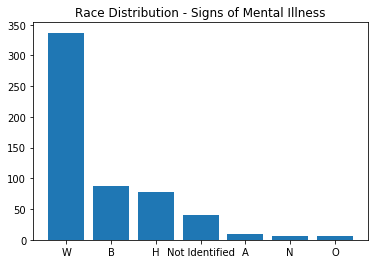

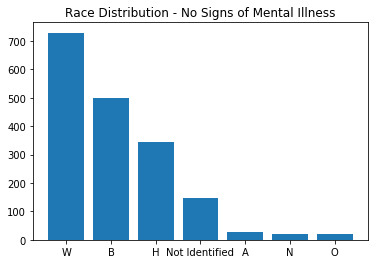

In [41]:
plt.bar(demo_killings_df[demo_killings_df.signs_of_mental_illness == True].race.value_counts().index, demo_killings_df[demo_killings_df.signs_of_mental_illness == True].race.value_counts().values)
plt.title('Race Distribution - Signs of Mental Illness')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.signs_of_mental_illness == False].race.value_counts().index, demo_killings_df[demo_killings_df.signs_of_mental_illness == False].race.value_counts().values)
plt.title('Race Distribution - No Signs of Mental Illness')
plt.show()

## Threat Level - Race Distribution

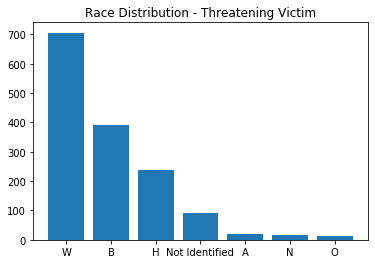

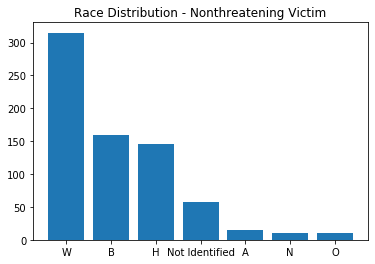

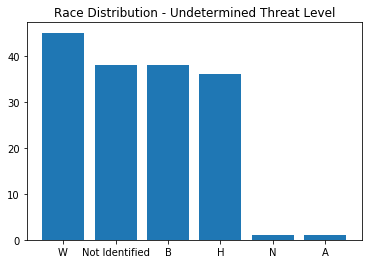

In [42]:
plt.bar(demo_killings_df[demo_killings_df.threat_level == 'attack'].race.value_counts().index, demo_killings_df[demo_killings_df.threat_level == 'attack'].race.value_counts().values)
plt.title('Race Distribution - Threatening Victim')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.threat_level == 'other'].race.value_counts().index, demo_killings_df[demo_killings_df.threat_level == 'other'].race.value_counts().values)
plt.title('Race Distribution - Nonthreatening Victim')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.threat_level == 'undetermined'].race.value_counts().index, demo_killings_df[demo_killings_df.threat_level == 'undetermined'].race.value_counts().values)
plt.title('Race Distribution - Undetermined Threat Level')
plt.show()

## Fleeing or Not - Race Distribution

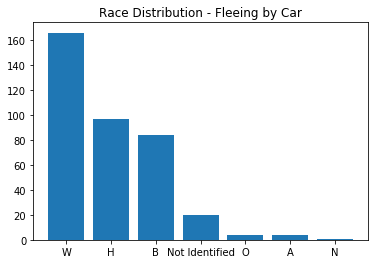

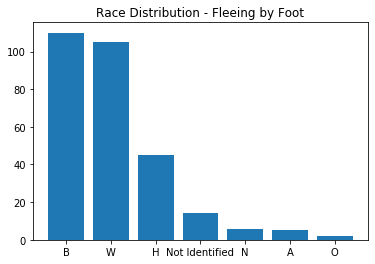

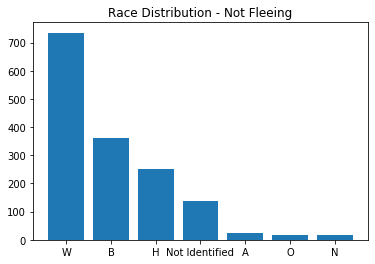

In [43]:
plt.bar(demo_killings_df[demo_killings_df.flee == 'Car'].race.value_counts().index, demo_killings_df[demo_killings_df.flee == 'Car'].race.value_counts().values)
plt.title('Race Distribution - Fleeing by Car')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.flee == 'Foot'].race.value_counts().index, demo_killings_df[demo_killings_df.flee == 'Foot'].race.value_counts().values)
plt.title('Race Distribution - Fleeing by Foot')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.flee == 'Not fleeing'].race.value_counts().index, demo_killings_df[demo_killings_df.flee == 'Not fleeing'].race.value_counts().values)
plt.title('Race Distribution - Not Fleeing')
plt.show()

## Armed vs Unarmed - Race Distribution

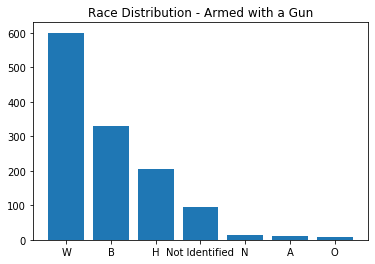

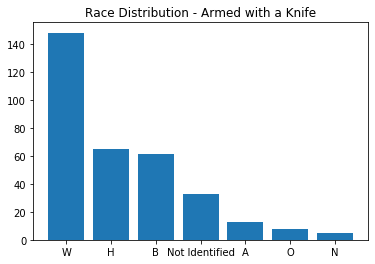

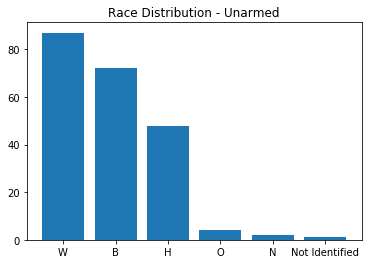

In [44]:
plt.bar(demo_killings_df[demo_killings_df.armed == 'gun'].race.value_counts().index, demo_killings_df[demo_killings_df.armed == 'gun'].race.value_counts().values)
plt.title('Race Distribution - Armed with a Gun')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.armed == 'knife'].race.value_counts().index, demo_killings_df[demo_killings_df.armed == 'knife'].race.value_counts().values)
plt.title('Race Distribution - Armed with a Knife')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.armed == 'unarmed'].race.value_counts().index, demo_killings_df[demo_killings_df.armed == 'unarmed'].race.value_counts().values)
plt.title('Race Distribution - Unarmed')
plt.show()

## Body Cameras - Race Distribution

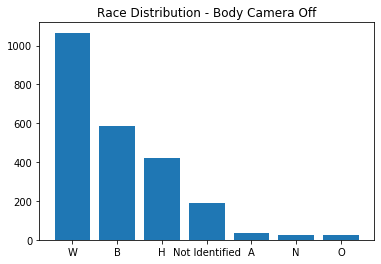

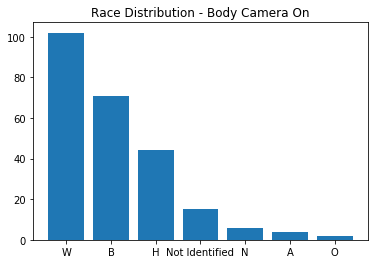

In [45]:
plt.bar(demo_killings_df.race.value_counts().index, demo_killings_df.race.value_counts().values)
plt.title('Race Distribution - Body Camera Off')
plt.show()

plt.bar(demo_killings_df[demo_killings_df.body_camera == True].race.value_counts().index, demo_killings_df[demo_killings_df.body_camera == True].race.value_counts().values)
plt.title('Race Distribution - Body Camera On')
plt.show()

In [46]:
def eda_charts(df):
    
    plt.bar(df.race.value_counts().index, df.race.value_counts().values)
    plt.title('Police Killings by Race')
    plt.show()
    
    plt.hist(df.poverty_rate)
    plt.title('Poverty Rate Distribution (%)')
    plt.show()
    
    plt.hist(df.percent_completed_hs)
    plt.title('High School Completion (% of Population) Distribution')
    plt.show()
    
    plt.hist(df.median_income)
    plt.title('Median Income Distribution')
    plt.show()

## Top 32 Cities

In [47]:
most_killings_df = demo_killings_df.loc[demo_killings_df['city'].isin(demo_killings_df.city.value_counts().index[:32])]

In [48]:
correlations(most_killings_df)

,age,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
age,1,0.0320506,0.0409949,0.121906,0.0400931,-0.189266,0.00224954,0.0427657,0.0740317
poverty_rate,0.0320506,1,-0.322493,-0.116913,0.333176,-0.146685,-0.206265,0.289368,-0.549076
percent_completed_hs,0.0409949,-0.322493,1,0.0447716,0.0144349,0.0448773,-0.0129527,-0.500997,0.381541
share_white,0.121906,-0.116913,0.0447716,1,-0.351996,-0.588355,-0.276833,0.217446,-0.0397265
share_black,0.0400931,0.333176,0.0144349,-0.351996,1,-0.221765,-0.156031,-0.336348,-0.169313
share_native_american,-0.189266,-0.146685,0.0448773,-0.588355,-0.221765,1,-0.171216,-0.267149,-0.151823
share_asian,0.00224954,-0.206265,-0.0129527,-0.276833,-0.156031,-0.171216,1,0.0666548,0.621847
share_hispanic,0.0427657,0.289368,-0.500997,0.217446,-0.336348,-0.267149,0.0666548,1,-0.171933
median_income,0.0740317,-0.549076,0.381541,-0.0397265,-0.169313,-0.151823,0.621847,-0.171933,1


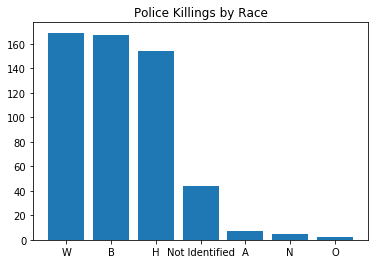

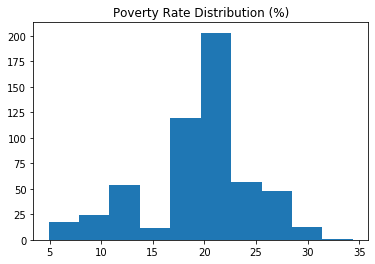

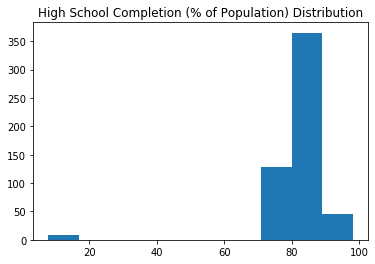

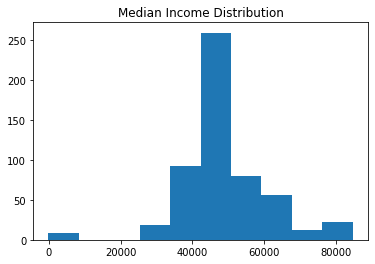

In [49]:
eda_charts(most_killings_df)

## Rest of Cities

In [50]:
rest_killings_df = demo_killings_df.loc[demo_killings_df['city'].isin(demo_killings_df.city.value_counts().index[32:])]

In [51]:
correlations(rest_killings_df)

,age,poverty_rate,percent_completed_hs,share_white,share_black,share_native_american,share_asian,share_hispanic,median_income
age,1,-0.0442289,0.0373841,0.188177,-0.113985,-0.0210043,-0.0676927,-0.105091,-0.00263708
poverty_rate,-0.0442289,1,-0.541382,-0.352101,0.381497,0.133254,-0.22285,0.103606,-0.751963
percent_completed_hs,0.0373841,-0.541382,1,0.367673,-0.130735,-0.0518855,0.0768151,-0.611952,0.446327
share_white,0.188177,-0.352101,0.367673,1,-0.744454,-0.152949,-0.336701,-0.248351,0.094281
share_black,-0.113985,0.381497,-0.130735,-0.744454,1,-0.118403,-0.113116,-0.197756,-0.276033
share_native_american,-0.0210043,0.133254,-0.0518855,-0.152949,-0.118403,1,-0.0606563,-0.0327561,-0.0690654
share_asian,-0.0676927,-0.22285,0.0768151,-0.336701,-0.113116,-0.0606563,1,0.138401,0.452094
share_hispanic,-0.105091,0.103606,-0.611952,-0.248351,-0.197756,-0.0327561,0.138401,1,0.0222794
median_income,-0.00263708,-0.751963,0.446327,0.094281,-0.276033,-0.0690654,0.452094,0.0222794,1


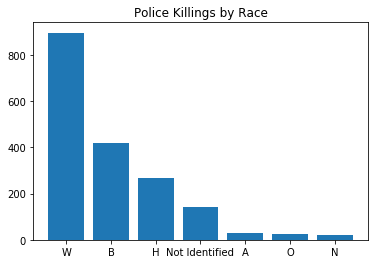

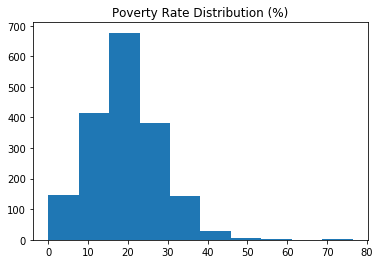

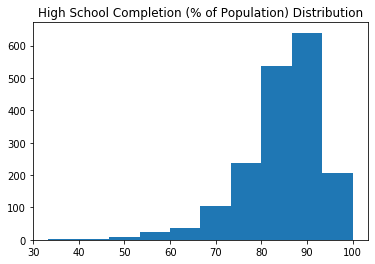

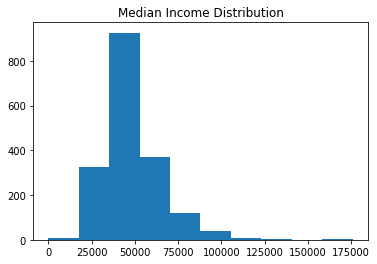

In [52]:
eda_charts(rest_killings_df)